<a href="https://colab.research.google.com/github/rts1988/Duolingo_spaced_repetition/blob/main/1_Introduction_basicEDA_Duolingo_spaced_repetition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <font color = 'cornflowerblue' size=4>Introduction</font>



Duolingo is a popular ed-tech company that gamifies language learning. It has a freemium business model, so increasing student engagement is vital. 

As part of its plan for increasing student engagement, Duolingo predicts how well a student might have retained the meanings and usage of words, and constructs a model of student’s understanding to produce targeted practice sessions that review words before are forgotten, and maximize retention (see below image). These indicators allows learners to better plan their study time, encouraging better retention, and therefore increasing motivation to continue using Duolingo.  

**ADD image here**
<figcaption align = "left"><b>Fig.1 -Duolingo strength meter</b></figcaption>

This series of notebooks is the code for a capstone project in predicting how well a student has remembered a word to fill in the strength meters for every word the student has learned, based on a replication dataset published by B. Settles and B. Meeder. 2016. [A Trainable Spaced Repetition Model for Language Learning](https://github.com/duolingo/halflife-regression/blob/master/settles.acl16.pdf). In _Proceedings of the Association for Computational Linguistics (ACL)_, pages 1848-1858.

In my capstone, using the dataset provided, the following questions are explored:

<font color='cornflowerblue' size=1>
Q1) What makes words difficult or easy for a student to remember?</font>

In addition to the sparse lexeme tags provided in the dataset, a number of word-based features are considered, such as the IDF of the word in English, the lexical similarity of the word in the language being learned, and the learner's native language, and word embeddings.

Classical machine learning techniques such as logistic regression, SVM, kNN, decision trees, ensemble techniques such as random forests, XGBoost, and finally, neural nets are trained and compared.

The test set for Q1 consists of words not seen in the training data. 

<font color='cornflowerblue' size=1>
Q2) What learning habits increase a student's retention?
</font>

Although the dataset only spans a short time, student performance as a function of time is encoded in daily average features in a manner similar to a time series, and added to the best model of Q1 to see how prediction performance improves. 

The test set for Q2 consists of students not seen in the training data. 

<font color='cornflowerblue' size=1>
Q3) The cold-start problem: Duolingo is always adding new language courses, might good predictions based on learnings from Q1 and Q2 be possible for a NEW LANGUAGE?
</font> 

The best model from Q2 is tested on two new languages courses unseen by the model.

The dataset spans 14 days of students learning second languages through Duolingo’s gamified system and has 12.8 million records and 12 variables.

**Feature sets:**

How well a word is retained depends on the word itself, and the student’s individual learning pace and capacity. The following features were provided in the dataset. 

**_Interaction features:_**
includes total number of times a student has seen the word $x_n$, the number of times it was correctly recalled, the number of times incorrectly recalled. 

**_Lexeme tag features:_** meant to capture the inherent difficulty of each particular word.

In the dataset, the lexeme string has a format like below: 
```"surface form/lemma<pos><modifiers>"```

For instance ```
hombre/hombre<n><m><sg>``` - where hombre ('man' in Spanish) has a lemmatized form 'hombre', is a noun (```<n>```), and has modifier tags ```<m>``` and ```<sg>```

Link for dataset download:
https://paperswithcode.com/dataset/duolingo-spaced-repetition-data

Data dictionary: 

-   `p_recall` - proportion of exercises from this lesson/practice where the word/lexeme was correctly recalled
-   `timestamp` - UNIX timestamp of the current lesson/practice
-   `delta` - time (in seconds) since the last lesson/practice that included this word/lexeme
-   `user_id` - student user ID who did the lesson/practice (anonymized)
-   `learning_language` - language being learned
-   `ui_language` - user interface language (presumably native to the student)
-   `lexeme_id` - system ID for the lexeme tag (i.e., word)
-   `lexeme_string` - lexeme tag (see below)
-   `history_seen` - total times user has seen the word/lexeme prior to this lesson/practice
-   `history_correct` - total times user has been correct for the word/lexeme prior to this lesson/practice
-   `session_seen` - times the user saw the word/lexeme during this lesson/practice
-   `session_correct` - times the user got the word/lexeme correct during this lesson/practice

Here $p\_recall = \frac{session\ correct}{session\ seen}$

In the rest of this notebook, we will clean the downloaded dataset, and do some preliminary EDA to understand the breadth and depth of the data. 

The dataset was downloaded to my Google drive, and is now copied to the notebook. 

#### <font color = 'cornflowerblue' size = 3>Reading data:</font>

In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fileid = "1MdLRV3GQ76-xqSGkH1QUDQ1MHrg_JtU_"
filename = "settles.acl16.learning_traces.13m.csv.gz"

# download the file to notebook
downloaded = drive.CreateFile({'id':fileid}) 
downloaded.GetContentFile(filename)

The file is unzipped to get a csv file, and data processing libraries are imported below. 

In [3]:
# from https://www.tutorialspoint.com/python-support-for-gzip-files-gzip
import gzip
import shutil
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools
datacsv = []
with gzip.open("settles.acl16.learning_traces.13m.csv.gz", 'rb') as f_in:
  with open("settles.acl16.learning_traces.13m.csv", 'wb') as f_out:
    shutil.copyfileobj(f_in, f_out)

Reading into a pandas dataframe:

In [4]:
datadf = pd.read_csv("settles.acl16.learning_traces.13m.csv")

## <font color='cornflowerblue' size = 4>Basic EDA</font>

### <font color = 'cornflowerblue' size=3>Sanity Checks</font>

Dimensions of the dataset:

In [5]:
datadf.shape

(12854226, 12)

The size of the dataframe in memory:

In [6]:
print(f"Size of dataframe: {datadf.size/10**6} MB")

Size of dataframe: 154.250712 MB


There are 12.85 million records and 12 columns, taking up 154.2 MB of memory. 

The first few records are displayed below: 

In [7]:
datadf.head(4)

,p_recall,timestamp,delta,user_id,learning_language,ui_language,lexeme_id,lexeme_string,history_seen,history_correct,session_seen,session_correct
0,1.0,1362076081,27649635,u:FO,de,en,76390c1350a8dac31186187e2fe1e178,lernt/lernen<vblex><pri><p3><sg>,6,4,2,2
1,0.5,1362076081,27649635,u:FO,de,en,7dfd7086f3671685e2cf1c1da72796d7,die/die<det><def><f><sg><nom>,4,4,2,1
2,1.0,1362076081,27649635,u:FO,de,en,35a54c25a2cda8127343f6a82e6f6b7d,mann/mann<n><m><sg><nom>,5,4,1,1
3,0.5,1362076081,27649635,u:FO,de,en,0cf63ffe3dda158bc3dbd55682b355ae,frau/frau<n><f><sg><nom>,6,5,2,1


It appears that each record is for one user learning one word, with the history of that word for that user, and particulars of language, and the number of questions for that word in that session.

From looking at the first few values of timestamp (all the same values), it probably marks the beginning of a learning session where each word learned in that session is listed in a separate record. 

Getting more information on the contents:

In [8]:
datadf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12854226 entries, 0 to 12854225
Data columns (total 12 columns):
 #   Column             Dtype  
---  ------             -----  
 0   p_recall           float64
 1   timestamp          int64  
 2   delta              int64  
 3   user_id            object 
 4   learning_language  object 
 5   ui_language        object 
 6   lexeme_id          object 
 7   lexeme_string      object 
 8   history_seen       int64  
 9   history_correct    int64  
 10  session_seen       int64  
 11  session_correct    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 1.1+ GB


The columns are listed on basis of datatype in the table below:

| Categorical       	| Numerical         	| Time based 	|
|-------------------	|-------------------	|------------	|
| lexeme_id         	| p_recall (target) 	| Timestamp  	|
| lexeme_tag        	| history_correct   	| delta      	|
| learning_language 	| history_seen      	|            	|
| ui_language       	| session_correct   	|            	|
| user_id           	| session_seen      	|            	|

Basic descriptive statistics for the numerical columns are below:

In [9]:
datadf.describe().T

,count,mean,std,min,25%,50%,75%,max
p_recall,12854226.0,8.961056e-01,2.714048e-01,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
timestamp,12854226.0,1.362589e+09,2.932082e+05,1.362076e+09,1.362343e+09,1.362591e+09,1.362846e+09,1.363105e+09
delta,12854226.0,7.295811e+05,2.246499e+06,1.000000e+00,5.320000e+02,7.713400e+04,4.425070e+05,4.032836e+07
history_seen,12854226.0,2.198109e+01,1.295508e+02,1.000000e+00,3.000000e+00,6.000000e+00,1.500000e+01,1.351800e+04
history_correct,12854226.0,1.935025e+01,1.119681e+02,1.000000e+00,3.000000e+00,6.000000e+00,1.300000e+01,1.288800e+04
session_seen,12854226.0,1.817686e+00,1.360180e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,2.000000e+01
session_correct,12854226.0,1.644134e+00,1.318794e+00,0.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,2.000000e+01


From count, there are no null values in the numerical columns. The min and max values show no strange, improbable values. 

Checking for null values:

In [10]:
datadf.isna().any()

p_recall             False
timestamp            False
delta                False
user_id              False
learning_language    False
ui_language          False
lexeme_id            False
lexeme_string        False
history_seen         False
history_correct      False
session_seen         False
session_correct      False
dtype: bool

There are no null values. 

Checking for duplicates:

In [11]:
datadf[datadf.duplicated()]

,p_recall,timestamp,delta,user_id,learning_language,ui_language,lexeme_id,lexeme_string,history_seen,history_correct,session_seen,session_correct
3067848,0.75,1362334650,6037137,u:fyCE,es,en,86584daef5933b284384453795bbf0ed,hombre/hombre<n><m><sg>,4,3,4,3
3067849,0.80,1362334650,6037137,u:fyCE,es,en,605a1c36da2cf22706eaad95b0b7eeee,niño/niño<n><m><sg>,3,3,5,4
3402349,0.50,1362353111,426085,u:zD_,fr,en,c5059c4d9d73f25a415904bade8a1337,posé/poser<vblex><pp><m><sg><@compound_past>,25,12,2,1
3402354,0.00,1362353111,3906547,u:zD_,fr,en,22ba409694ae64f3768d993f4b81708f,parliez/parler<vblex><pii><p2><pl>,1,1,1,0
3402355,1.00,1362353111,435992,u:zD_,fr,en,c4d97966fdca70e0964004f50ff50d66,entièrement/entièrement<adv>,20,11,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
7702861,1.00,1362683117,82,u:i5X3,en,es,c52ab45d4e22ee7580041911159e3c0c,water/water<n><sg>,5,4,1,1
7722347,1.00,1362684186,331356,u:gMHD,en,es,1849080c74cfc80bb39a5a493e85efe8,see/see<vblex><inf>,17,15,1,1
7722348,0.00,1362684186,330165,u:gMHD,en,es,019e69c0c7349a49fff531b7c5fc263c,have/have<vbhaver><pres><@present_perfect>,73,66,1,0
7722349,0.00,1362684186,77803,u:gMHD,en,es,e09b138d58a98c83f120ffbc898ce818,at/at<pr>,61,54,1,0


There are 81 duplicate rows. 

Deleting duplicate rows:

In [12]:
datadf = datadf.drop_duplicates()

In [13]:
datadf.shape

(12854145, 12)

A quick look at the distributions of numerical and time based columns:

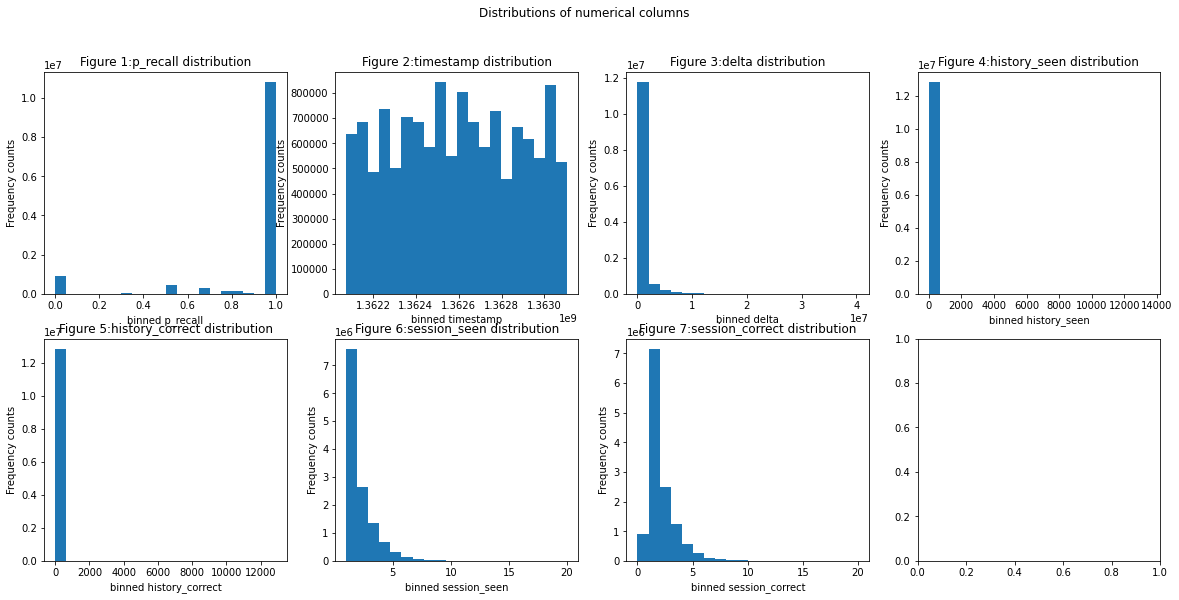

In [14]:
plt.subplots(2,4,figsize = (20,9))
plt.suptitle("Distributions of numerical columns")
plot_num = 1
for col in datadf.select_dtypes(exclude= ['object']).columns: # filtering out 'object' datatypes to only numerical columns
  plt.subplot(2,4,plot_num)
  plt.xlabel(f"binned {col}")
  plt.ylabel(f"Frequency counts")
  plt.hist(datadf[col],bins=20)
  plt.title(f"Figure {plot_num}:{col} distribution")
  plot_num +=1

**Observations**: 
1. From Figure 1, we see that in the overwhelming majority of p_recall = 1, meaning that the word was perfectly retained. This is a **highly imbalanced dataset**.
2. Timestamp (Figure 2) is fairly uniformly distributed - meaning that there are close to the same number of records for each day.  
3. Figure 3 shows that delta is skewed heavily to the right, with most values being close to zero.
4. Figures 4 and 5 (history seen and history correct) are heavily skewed to the right. Most values are low, showing that many new words are being learned. 
5. Figures 6 and 7 (session seen and session correct) show that the number of times a word is encountered in a session is typically ~ 1. 

Basic information on the categorical columns is obtained using the wrapper function defined below:

In [15]:
def categorical_describe(df_cat): # function to take in the df containing categrical columns 
    # and return information in a dataframe format for display

  datatype = dict()
  most_common = dict()
  most_common_frac = dict()
  num_unique = dict()
  num_null_vals = dict()
  num_empty_vals = dict()

  for col in df_cat.columns: # go through each column 
    datatype[col] = type(df_cat[col].head(1).values[0]) # get datatype
    
    # get the most frequent value and its corresponding percentage counts in column
    top_val = df_cat[col].value_counts(normalize=True).sort_values(ascending=False).head(1) 
    most_common[col] = top_val.index[0]
    most_common_frac[col] = top_val.values[0]
    
    # get number of unique values
    num_unique[col] = len(df_cat[col].unique())
    
    # get number of null values
    num_null_vals[col] = df_cat[col].isna().sum()
    
    # get number of empty strings
    # strip spaces and then count characters- if 0, then it is 'empty string'
    if datatype[col]==str:
        num_empty_vals[col] = df_cat[col].apply(lambda x: len(x.rstrip().lstrip())==0).sum() 
    else:
        num_empty_vals[col] = 0

  return pd.DataFrame({'datatype':pd.Series(datatype), 'most_common':pd.Series(most_common),
                       'most_common_fraction':pd.Series(most_common_frac),
                       'number_unique_values': pd.Series(num_unique),
                       'number_null_values':pd.Series(num_null_vals),
                      'number_empty_vals': pd.Series(num_empty_vals)})
  


In [16]:
df_cat = datadf.select_dtypes(include=['object']) # creating view of dataframe with categoricals only

In [17]:
categorical_describe(df_cat)

,datatype,most_common,most_common_fraction,number_unique_values,number_null_values,number_empty_vals
user_id,<class 'str'>,u:bcH_,0.001493,115222,0,0
learning_language,<class 'str'>,en,0.390129,6,0,0
ui_language,<class 'str'>,en,0.609871,4,0,0
lexeme_id,<class 'str'>,827a8ecb89f9b59ac5c29b620a5d3ed6,0.009577,19279,0,0
lexeme_string,<class 'str'>,a/a<det><ind><sg>,0.009577,18781,0,0


**Observations**:

1. There are 115,222 unique users in the dataset. 
2. There are 6 learning languages, and 4 native languages in the dataset. 
3. English makes up 39% of the languages being learned, and 61% of the native language of learners. 
4. There are 19,279 individual lexeme_ids, but only 18,781 lexeme strings. This might be because there are words that are common to more than one language and therefore have the same lexeme string. The lexeme ```"a"``` is the most commonly encountered one, making up almost 1% of the dataset. 
5. There are no null or empty string values. 


### <font color = 'cornflowerblue' size=3>Target variable analysis and transformation:</font>

Previously, it was seen that the distribution of recall probability was highly imbalanced. The histogram is reproduced below:

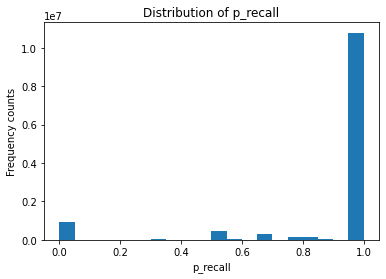

In [18]:
plt.figure()
plt.title("Distribution of p_recall")
plt.xlabel("p_recall")
plt.ylabel("Frequency counts")
plt.hist(datadf['p_recall'],bins=20)
plt.show()

The values of p_recall are discretely distributed because they are computed from session correct and session_seen columns, which in turn are integers. 

p_recall is being calculated as the fraction of the number of questions in the session related to that word answered correctly. 

Plotting the distribution of p_recall as a function of session_seen:

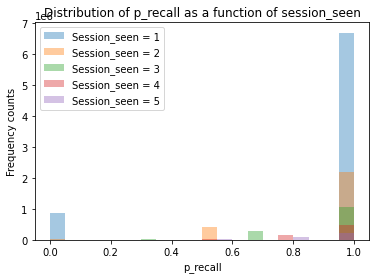

In [19]:
plt.figure()
plt.title("Distribution of p_recall as a function of session_seen")
plt.xlabel("p_recall")
plt.ylabel("Frequency counts")
for n in range(1,6): # this range is chosen since the most common bracket of session_seen values was between 1-5. 
  plt.hist(datadf.loc[datadf['session_seen']==n,'p_recall'],bins=20,label=f"Session_seen = {n}",alpha=0.4)
plt.legend()
plt.show()

There is an interesting relationship between the distribution of recall probability, and the number of questions seen in the session related to a word. 

For a session_seen = 1, the recall probability has only 2 values: 0 and 1.

For session_seen = 2, p_recall is almost never zero, and is either 0.5 (or $\frac{1}{2}$) or 1. 

For session_seen = 3, p_recall is almost never zero, and is either 0.66 (or $\frac{2}{3}$) or 1.

For session_seen = 4, p_recall is almost never zero, and is either 0.75 (or $\frac{3}{4}$) or 1.

For session_seen = 5, p_recall is almost never zero, and is either 0.80 (or $\frac{4}{5}$) or 1.

<font color = 'cornflowerblue' size=0.9>
As a Duolingo user myself, I know that if I answer a question incorrectly, feedback in the form of the correct answer is provided immediately. Effectively, delta (duration between word encounters) is set to 0 the moment feedback is provided.</font>


It appears that students are able to retain the immediate feedback, and answer all but one questions of a word they had forgotten, correctly. 

The target variable is therefore transformed so that if a single question is answered incorrectly, it is assumed to have been forgotten. 

$p\_forgot = 1 - p\_recall$<br>
$p\_forgot\_bin = 1\ if\ p\_forgot\ >\ 0,\ otherwise\ 0$<br>


In [20]:
# transforming target variable
datadf['p_forgot'] = 1 - datadf['p_recall']
datadf['p_forgot_bin'] = np.where(datadf['p_forgot']>0,1,0) # conservative approach - if p_forgot is not zero, it must be 1. 

Distribution of tranformed target variable:

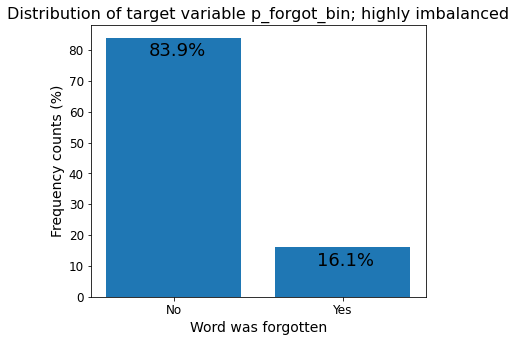

In [21]:
counts = np.around(datadf['p_forgot_bin'].value_counts(normalize=True)*100,2)
plt.figure(figsize=(6,5))
plt.bar(counts.index,counts)
plt.xticks([0,1],fontsize=12,labels = ['No','Yes'])
plt.yticks(fontsize=12)
plt.ylabel("Frequency counts (%)",fontsize=14)
plt.xlabel("Word was forgotten",fontsize=14)
plt.title("Distribution of target variable p_forgot_bin; highly imbalanced",fontsize=16)
plt.annotate("83.9%",(0-.15,78),fontsize=18,c='black')
plt.annotate("16.1%",(1-.15,10),fontsize=18,c='black')
plt.show()

In spite of the conservative approach of marking a word as forgotten if even one question was answered incorrectly in the session, there are only 16.1% records where a word is forgotten. As a binary classification problem, the dataset is **imbalanced**. 

This might be because Duolingo (at the time this dataset was collected), was **underpredicting retention**, and assuming students have forgotten words when they have not, making students practice words they already know many times over.  

A more accurate model will help to reduce boredom in students (and increase engagement) by pinpointing only words that are truly forgotten. Therefore, for a metric for classification model performance and comparison, **average precision** will be used, and prioritized over perfect recall. 


### <font color = 'cornflowerblue' size=3>What language courses are offered?</font>

To look at the language courses being offered, learning language and native language are cross-tabulated below:

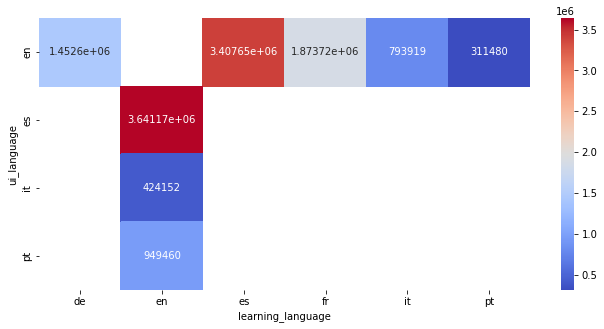

In [41]:
import numpy.ma as ma
ctable = pd.crosstab(datadf['ui_language'],datadf['learning_language'])
# INSERT HERE add a mask for zero values. 
plt.figure(figsize=(11,5))
sns.heatmap(ctable.where(ctable>0),cmap="coolwarm",annot=True,fmt='g')
plt.show()

The numbers in the table above show the number of records for each course. 

The dataset has Spanish, Italian and Portugese speaking students learning English.

English speaking students are learning German, Spanish, Italian, Portugese, and French.

There are no odd values like learning language and native language being the same.

#### Unique words in each language

In [42]:
 # count of number of unique words in each learning language
numwords_perlang = datadf.groupby('learning_language')['lexeme_id'].unique().apply(len).sort_values(ascending=False)

In [43]:
numwords_perlang

learning_language
fr    4184
de    3809
es    3302
en    2983
pt    2815
it    2186
Name: lexeme_id, dtype: int64

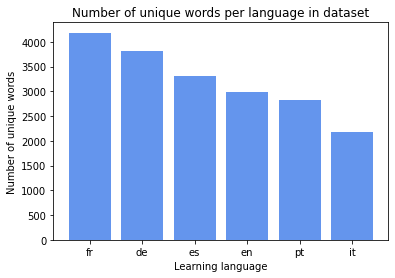

In [44]:
# plotting bar chart of number of unique words per language. 
plt.figure()
plt.bar(numwords_perlang.index,numwords_perlang,color='cornflowerblue')
plt.title("Number of unique words per language in dataset")
plt.xlabel("Learning language")
plt.ylabel("Number of unique words")
plt.show()

The dataset has 4184 unique French words being learned, followed by 3809 German words, and 3302 Spanish words. 

###<font color = 'cornflowerblue' size=3>Lexical similarity: Are languages with more shared vocabulary with English easier to learn?</font>

Previously, it was seen that there were more unique values of lexeme_id than lexeme_string, (in other words, not a one-to-one mapping). This is possibly because of words that are common to two or more languages, having unique ids, but the same lexeme strings. 

Listing the lexeme_string values with more than one language below:

In [45]:
# getting number of languages for each lexeme string
lexeme_numlanguages = datadf.groupby('lexeme_string')['learning_language'].unique().apply(len).sort_values(ascending=False) 

# counting the number of lexeme strings with more than one language
lexeme_numlanguages[lexeme_numlanguages>1].shape[0]

462

There are 462 words that are common to two or more languages in the dataset. 

This leads to a **hypothesis that if native and learning languages have words in common, those words are highly likely to be remembered correctly.**

In later notebooks, string distance measures are investigated as potential predictors of recall probability. 

A rough value of lexical similarity (how similar the vocabularies of two languages are) might also be computed from the pandas series above. It might partially explain the inherent difficulty of learning a language A while being a language B speaker. 

In the code block below, a ratio of common words and different words in each language pair is calculated. 

In [46]:
# For each pair of languages, the number of words that are common to them.

similar_over_different = dict()

# list of learning languages
learnlang_list = datadf['learning_language'].unique()

for (L1,L2) in itertools.combinations(learnlang_list, 2): # iterating over every pair of learning languages
  # set of lexeme strings in L1
  L1strings = set(datadf.loc[datadf['learning_language']==L1,'lexeme_string'])
  # set of lexeme strings in L1
  L2strings = set(datadf.loc[datadf['learning_language']==L2,'lexeme_string'])
  # compute the number of common words between Languages L1 and L2
  commonwords =  L1strings.intersection(L2strings)
  num_commonwords = len(commonwords)

  # number of words only in 1 of the languages 
  not_in_commonwords = L1strings.symmetric_difference(L2strings)
  num_not_in_commonwords = len(not_in_commonwords)

  # computing and saving lexical similarity to dictionary
  similar_over_different[(L1,L2)] = num_commonwords/num_not_in_commonwords


In [50]:
similar_over_different = pd.Series(similar_over_different)
similar_over_different.sort_values(ascending=False)

es  pt    0.046649
pt  it    0.022571
es  it    0.012706
pt  fr    0.004614
es  fr    0.004447
fr  it    0.003160
de  fr    0.000752
en  it    0.000581
es  en    0.000159
de  pt    0.000151
    en    0.000147
    es    0.000000
    it    0.000000
pt  en    0.000000
en  fr    0.000000
dtype: float64

Spanish, Italian and Portuguese share a significant number of words. French to a lesser extent shares words with the Latin languages. On the other hand, English and French share no words, nor do Portuguese and English, German and Spanish and German and Italian. 

This is aligned with computations of lexical similarity as seen in the table reproduced below from [wikipedia](https://en.wikipedia.org/wiki/Lexical_similarity)

In [51]:
lexical_simwiki = pd.DataFrame([[1,0.27,0.6,None,None,None],\
                                [0.27,1,0.29,0.89,0.75,0.75],\
                                [0.6,0.29,1,None,None,None],\
                                [None,0.89,None,1,None, 0.82],\
                                [None,0.75,None,None,1,0.89],\
                                [None,0.75,None,0.82,0.89,1]],index= ['English','French','German','Italian','Portuguese','Spanish'],columns = ['English','French','German','Italian','Portuguese','Spanish'])

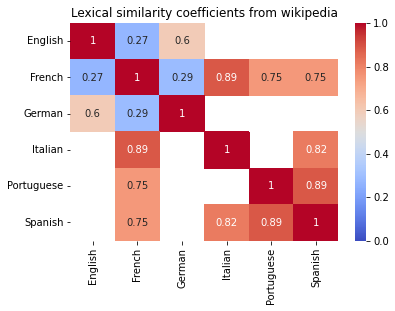

In [52]:
plt.figure()
plt.title("Lexical similarity coefficients from wikipedia")
sns.heatmap(lexical_simwiki,cmap="coolwarm",vmin=0,vmax=1,annot=True)
plt.show()

An image from graphical analysis of lexical similarity is below: 

INSERT HERE. 

The relative percentage of records with forgotten words is plotted by learning language below in a bar chart. The annotations are the percentage of forgotten words for each language.

<Figure size 864x432 with 0 Axes>

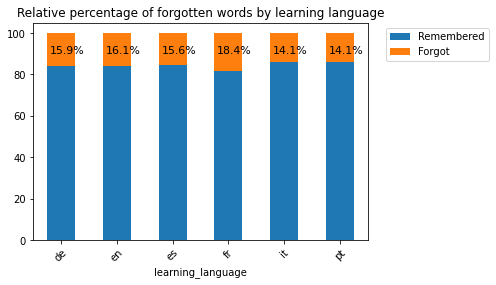

p_forgot_bin,0,1
learning_language,,
de,84.1,15.9
en,83.9,16.1
es,84.4,15.6
fr,81.6,18.4
it,85.9,14.1
pt,85.9,14.1


In [53]:
# Tabulating the WNV test results across the different mosquito species. 
ctable = pd.crosstab(datadf['learning_language'],datadf['p_forgot_bin']).apply(lambda x:x/sum(x)*100,axis = 1)

#display(HTML('<b>Relative percentage of WNV positive mosquito samples by species'))
plt.figure(figsize=(12,6))
ctable.plot(kind ='bar',stacked=True)
plt.title('Relative percentage of forgotten words by learning language')
plt.legend(bbox_to_anchor=(1.04,1),labels = ['Remembered','Forgot'])
plt.xticks(rotation = 45)

for i,ind in enumerate(ctable.index):
  plt.annotate(str(ctable.loc[ind,1].round(1))+"%",(i-0.2,90),fontsize=11,c='black')
plt.show()

INSERT HERE: chi-square test, for languages. consider 

French with a lexical similarity of 0.27 with English has a higher percentage of forgotten words compared to German, which has a lexical similarity of 0.6 with English. 

For the **cold-start problem** with new languages, the above analysis might be useful. 

### <font color='cornflowerblue' size=3>Transforming time variables:</font>

Converting timestamp to a datetime object:

In [54]:
# converting timestamp to datetime object
from datetime import datetime
datadf['Datetime'] = datadf['timestamp'].apply(lambda x: datetime.fromtimestamp(x))
datadf['Datetime'].head()

0   2013-02-28 18:28:01
1   2013-02-28 18:28:01
2   2013-02-28 18:28:01
3   2013-02-28 18:28:01
4   2013-02-28 18:28:01
Name: Datetime, dtype: datetime64[ns]

In [55]:
datadf['Datetime'].describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                12854145
unique                 574814
top       2013-03-05 21:09:36
freq                      217
first     2013-02-28 18:28:01
last      2013-03-12 16:14:57
Name: Datetime, dtype: object

The dataset spans 13 days from 28 Feb, 2013 to 12 Mar, 2013. 

The distribution of delta in the histograms above show that there are a large number of low values. Looking at the counts of the 15 lowest values of delta.

In [ ]:
datadf['delta'].value_counts().sort_index(ascending=True).head(15)

There are surprosingly records with delta as low as 1 - 15 seconds! No wonder the dataset is imbalanced. One would expect that differing results in two session records <=15 seconds apart is more a function of the student either not paying focused attention or not understanding the concept, rather than an effect of memory.  

Transforming delta to days for visualization:

In [56]:
datadf['delta_days'] = datadf['delta']/60/60/24

# How many records have delta < 1 day?
datadf[datadf['delta_days']<1].shape[0]/datadf.shape[0]*100

52.97252364898638

The percentage of records that have delta < 1 day (reviewed on the same day) is 53%. This might also partially explain why the target variable p_forgot_bin is so heavily skewed towards remembering words perfectly.

### <font color = 'cornflowerblue' size = 3>How does time since last review impact probability of forgetting a word?</font>

One would expect that forgotten words would on average have been reviewed a longer time ago. 

Delta is in seconds, and so is transformed to days for easier visualization:

In [57]:
# How many records have delta < 1 day?
datadf[datadf['delta_days']<1].shape[0]/datadf.shape[0]*100

52.97252364898638

The percentage of records that have delta < 1 day (reviewed on the same day) is 53%. This might also partially explain why the target variable p_forgot_bin is so heavily skewed. 

The distributions for delta in days for forgotten words and remembered words is plotted below: (blue is remembered words, orange is forgotten)

(0.0, 100.0)

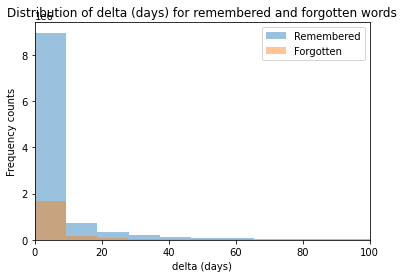

In [58]:
plt.figure()
plt.hist(datadf.loc[datadf['p_forgot_bin']==0,'delta_days'],bins=50,label="Remembered",alpha=0.45)
plt.hist(datadf.loc[datadf['p_forgot_bin']==1,'delta_days'],bins=50,label="Forgotten",alpha=0.45)
plt.legend()
plt.xlabel("delta (days)")
plt.ylabel("Frequency counts")
plt.title("Distribution of delta (days) for remembered and forgotten words")
plt.xlim((0,100))

The shapes of the distributions are similar: skewed to the right. 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


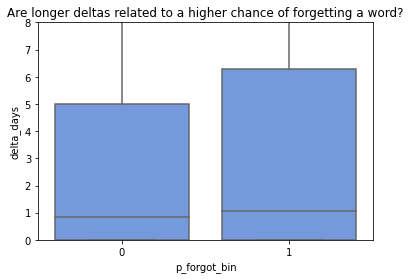

In [59]:
plt.figure()
plt.title("Are longer deltas related to a higher chance of forgetting a word?")
sns.boxplot(datadf['p_forgot_bin'],datadf['delta_days'],color='cornflowerblue')
plt.ylim((0,8))
plt.show()

At a glance, there is not much difference in the mean values of delta for forgotten words and remembered words. There is a great deal of overlap. 

Since delta is not normally distributed for either group, Kruskal-Wallis test is used to check if the two groups are significantly different. 
**INSERT HERE**
Assumptions:

Null hypothesis:
Alternate hypothesis: 

In [60]:
from scipy import stats
stats.kruskal(datadf.loc[datadf['p_forgot_bin']==0,'delta_days'], datadf.loc[datadf['p_forgot_bin']==1,'delta_days'])

KruskalResult(statistic=26094.40170342701, pvalue=0.0)

Another way of visualizing the effect of delta is the fraction of words forgotten for binned intervals of delta_days. 

INSERT HERE: make binned mean graphs into a function (DRY)

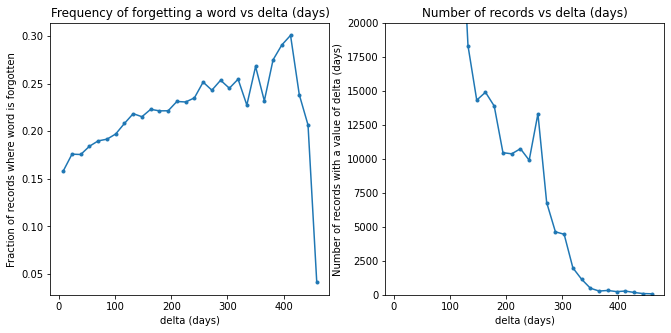

In [61]:
# binning values of delta
datadf['binned_deltadays'] = pd.cut(datadf['delta_days'],30)

# for each bin of delta, gettin the percentage of records with words forgotten
meanp_delta = datadf.groupby('binned_deltadays').agg(fraction_forgotten = ('p_forgot_bin','mean'), totalcount = ('p_forgot_bin','count'))
meanp_delta = meanp_delta.reset_index()
# getting the middle value of each bin interval
meanp_delta['binned_deltadays_mid'] = meanp_delta['binned_deltadays'].apply(lambda x: x.mid)

# plotting mid of interval and percentage of words forgotten within that interval
plt.subplots(1,2,figsize=(11,5))
#ax = plt.gca()
plt.subplot(1,2,1)
plt.plot(meanp_delta['binned_deltadays_mid'],meanp_delta['fraction_forgotten'],'.-')
plt.xlabel("delta (days)")
plt.ylabel("Fraction of records where word is forgotten")
plt.title("Frequency of forgetting a word vs delta (days)")

#ax = plt.gca()
plt.subplot(1,2,2)
plt.plot(meanp_delta['binned_deltadays_mid'],meanp_delta['totalcount'],'.-')
plt.xlabel("delta (days)")
plt.ylabel("Number of records with a value of delta (days)")
plt.ylim(0,20000)
plt.title("Number of records vs delta (days)")
plt.show()

plt.show()

- In the lineplot above, the fraction of forgotten words steadily increases with delta, as might be expected. However, there is a sharp drop at around 400 days. when the total count of records is reduced to < 200. For the majority of the records, probability of forgetting increases with delta.

At extremely low deltas (1-15 seconds), the mean probability of 'forgetting' is calculated below:

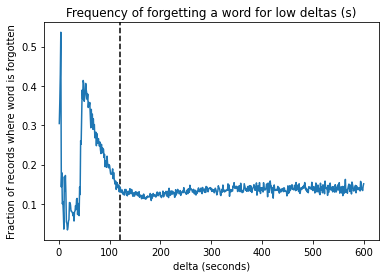

In [62]:
meanp_lowdelta = datadf.loc[datadf['delta']<=600,['delta','p_forgot_bin']].groupby('delta')['p_forgot_bin'].mean()
plt.figure()
plt.xlabel("delta (seconds)")
plt.ylabel("Fraction of records where word is forgotten")
plt.title("Frequency of forgetting a word for low deltas (s)")
plt.axvline(x=120,color='black',linestyle='--')
plt.plot(meanp_lowdelta.index,meanp_lowdelta)
plt.show()

The above plot is interesting and might be capturing real-time memory transfer phenomena. At very low delta values (0-50 seconds), probability of forgetting is quite low, possibly because the learned information is still in the learner's working memory. 

As the learner continues to learn other words, at some point the word might leave working memory and be transferred to long term memory with some initial probability of recalling it. 

There is then a period where probability of forgetting actually decreases, which is an interesting phenomenon. 

Past around 120 seconds, probability of forgetting slowly increases with increasing delta. 

The span of delta is huge (1 second to > 400 days). 



In [63]:
print("The percentage of records with delta < 15 minutes: ")
np.around(datadf.loc[datadf['delta']<900,:].shape[0]/datadf.shape[0]*100,1)

The percentage of records with delta < 15 minutes: 


30.9

A whopping 31 % of records have delta < 15 minutes.

If students are checking the retention strength meters as they are deciding what to study next, and are looking for a high retention reading to be satisfied that they have practiced a word enough, the model needs to account for the lower deltas as well as longer deltas. 

### <font color = "cornflowerblue" size=3>Is a learner's history with a word related to the probability of forgetting it in a session?</font>

A box plot of history_seen vs p_forgot_bin is below:

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


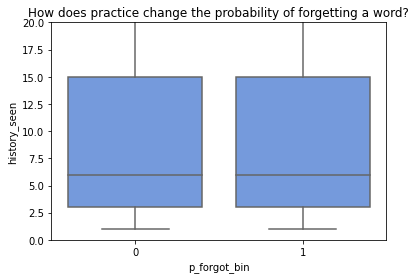

In [64]:
plt.figure()
plt.title("How does practice change the probability of forgetting a word?")
sns.boxplot(datadf['p_forgot_bin'],datadf['history_seen'],color='cornflowerblue')
plt.ylim((0,20))
plt.show()

There is virtually no difference between the mean value of history_seen for records with forgotten or remembered words. 

Since the distribution of history_seen is not normal (figure reproduced below), Kruskal-Wallis test is done

Null hypothesis
Alternate Hypothesis

**INSERT HERE**

In [65]:
stats.kruskal(datadf.loc[datadf['p_forgot_bin']==0,'history_seen'], datadf.loc[datadf['p_forgot_bin']==1,'history_seen'])

KruskalResult(statistic=101.7866889220487, pvalue=6.183426957396604e-24)

pvalue is << 0.05, indicating that the two groups have different means.

Looking at fraction of records with forgotten words for each interval of binned history_seen.

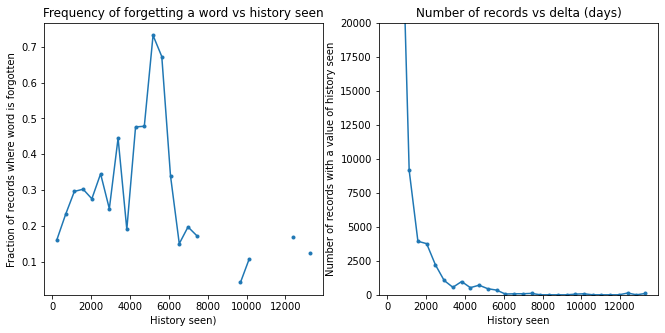

In [66]:
# binning values of delta
datadf['binned_hseen'] = pd.cut(datadf['history_seen'],30)

# for each bin of delta, gettin the percentage of records with words forgotten
meanp_hseen = datadf.groupby('binned_hseen').agg(fraction_forgotten = ('p_forgot_bin','mean'), totalcount = ('p_forgot_bin','count'))
meanp_hseen = meanp_hseen.reset_index()
# getting the middle value of each bin interval
meanp_hseen['binned_hseen_mid'] = meanp_hseen['binned_hseen'].apply(lambda x: x.mid)

# plotting mid of interval and percentage of words forgotten within that interval
plt.subplots(1,2,figsize=(11,5))
#ax = plt.gca()
plt.subplot(1,2,1)
plt.plot(meanp_hseen['binned_hseen_mid'],meanp_hseen['fraction_forgotten'],'.-')
plt.xlabel("History seen)")
#plt.xlim((0,4500))
plt.ylabel("Fraction of records where word is forgotten")
plt.title("Frequency of forgetting a word vs history seen")

#ax = plt.gca()
plt.subplot(1,2,2)
plt.plot(meanp_hseen['binned_hseen_mid'],meanp_hseen['totalcount'],'.-')
plt.xlabel("History seen")
plt.ylabel("Number of records with a value of history seen")
plt.ylim(0,20000)
plt.title("Number of records vs delta (days)")
plt.show()

plt.show()

There is no clear relationship between history_seen and probability of forgetting a word. 

Exploring a derived feature:

$history\_frac = \frac{history\_correct}{history\_seen}$

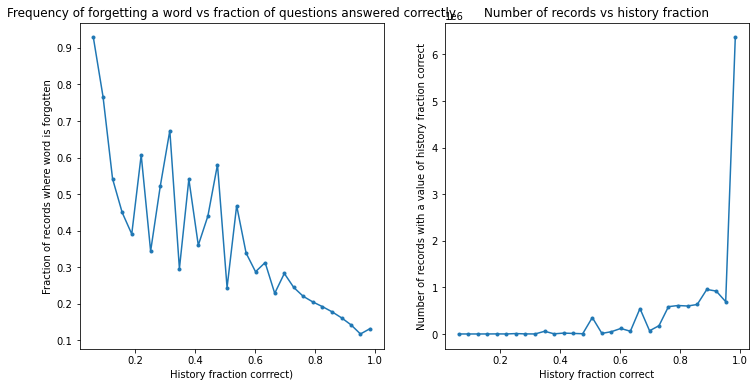

In [67]:
datadf['history_frac'] = datadf['history_correct']/datadf['history_seen']

datadf['binned_hfrac'] = pd.cut(datadf['history_frac'],30)

# for each bin of history fraction, getting the percentage of records with words forgotten
meanp_hfrac = datadf.groupby('binned_hfrac').agg(fraction_forgotten = ('p_forgot_bin','mean'), totalcount = ('p_forgot_bin','count'))
meanp_hfrac = meanp_hfrac.reset_index()
# getting the middle value of each bin interval
meanp_hfrac['binned_hfrac_mid'] = meanp_hfrac['binned_hfrac'].apply(lambda x: x.mid)

# plotting mid of interval and percentage of words forgotten within that interval
plt.subplots(1,2,figsize=(12,6))
#ax = plt.gca()
plt.subplot(1,2,1)
plt.plot(meanp_hfrac['binned_hfrac_mid'],meanp_hfrac['fraction_forgotten'],'.-')
plt.xlabel("History fraction corrrect)")
plt.ylabel("Fraction of records where word is forgotten")
plt.title("Frequency of forgetting a word vs fraction of questions answered correctly")

#ax = plt.gca()
plt.subplot(1,2,2)
plt.plot(meanp_hfrac['binned_hfrac_mid'],meanp_hfrac['totalcount'],'.-')
plt.xlabel("History fraction correct")
plt.ylabel("Number of records with a value of history fraction correct")
plt.title("Number of records vs history fraction")
plt.show()

Fraction of records with forgotten words shows a rough downward trend with increasing fraction of previous correct answers in history. This would be expected - at lower fractions, when a word is new, the changes of forgetting it are higher than when it has been encountered a number of times.  


### <font color="cornflowerblue" size=3>How long are individual time traces of one student learning one word?</font>

Looking at the number of individual time traces with one learner practicing one word over the duration of the dataset. 

In [68]:
timetraces = datadf.groupby(['user_id','lexeme_id'])['timestamp'].count()
timetraces.head(10)

user_id  lexeme_id                       
u:--N    01a14ea3963721a9d545dce1acc30f2f    1
         087d9d0736df444d7ef826a313b613da    1
         0cf63ffe3dda158bc3dbd55682b355ae    1
         20dde14c9907e353804d0de13f198543    1
         219c91b94b90fec1d764a61b8011cf33    1
         4635584da9ff676724eca4ade50daa8b    1
         495f763ef6027e020c53431484aa5ede    1
         55f59c70aebebb0d12d8651daf33d9c7    1
         598a41cd84310715e45b6192564592a1    1
         68b3cc8b3dd20813c27711cbf0fc5f15    1
Name: timestamp, dtype: int64

In [69]:
timetraces.shape[0]

5861629

There are 5.86 million timetraces, with a number of traces with just one record. 

In [70]:
timetraces[timetraces<=2].shape[0]/timetraces.shape[0]*100

76.0229110371878

Around 76% of the dataset is traces with just 2 or fewer records. The plot below is a distribution of number of records of traces (records of one word being reviewed by one student). 

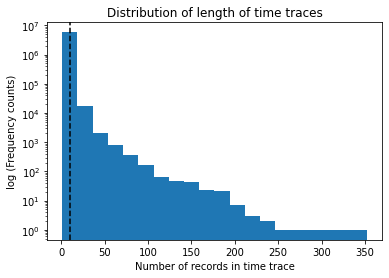

In [71]:
plt.figure()
plt.title("Distribution of length of time traces")
plt.xlabel("Number of records in time trace")
plt.ylabel("log (Frequency counts)")
plt.hist(timetraces,log=True,bins=20)
plt.axvline(10,color='black',linestyle='--')
plt.show()

In [104]:
timetraces.sort_values(ascending=False)

user_id  lexeme_id                       
u:bcH_   1e1f8d730c4ba99ad2873a7608324cf6    352
         6d4c572af8022cb4784ce0f8898d1905    328
         33a7fd42f74b2d2b1110f1b0c8b6db38    316
         827a8ecb89f9b59ac5c29b620a5d3ed6    295
         97e922f780d628eac638bea7a02bf496    278
                                            ... 
u:h2vI   62a090db014ab03963712da6c4a76f13      1
         631d297c324518ea97ac01fd2abd6e46      1
         65675f993b9cdc38918837f561a70625      1
         690243b9e6d1652ba20cf78adad15b20      1
u:hKyL   64fb4435d0bd27297be2771ef6f09865      1
Name: timestamp, Length: 5861629, dtype: int64

Although the majority of traces involve 2 or fewer records, there are a substantial number of traces with >10 records. 

Traces from one student (INSERT HERE) learning three different words INSERT HERE are visualized below:

In [112]:
datadf.loc[datadf['lexeme_id']=='827a8ecb89f9b59ac5c29b620a5d3ed6','lexeme_string'].head(1)

176    a/a<det><ind><sg>
Name: lexeme_string, dtype: object

In [105]:
trace_1 = datadf.loc[(datadf['user_id']=='u:bcH_') & (datadf['lexeme_id']=='1e1f8d730c4ba99ad2873a7608324cf6'),['Datetime','p_forgot_bin']].sort_values(by='Datetime',ascending=True)
trace_2 = datadf.loc[(datadf['user_id']=='u:bcH_') & (datadf['lexeme_id']=='6d4c572af8022cb4784ce0f8898d1905'),['Datetime','p_forgot_bin']].sort_values(by='Datetime',ascending=True)
trace_3 = datadf.loc[(datadf['user_id']=='u:bcH_') & (datadf['lexeme_id']=='827a8ecb89f9b59ac5c29b620a5d3ed6'),['Datetime','p_forgot_bin']].sort_values(by='Datetime',ascending=True)



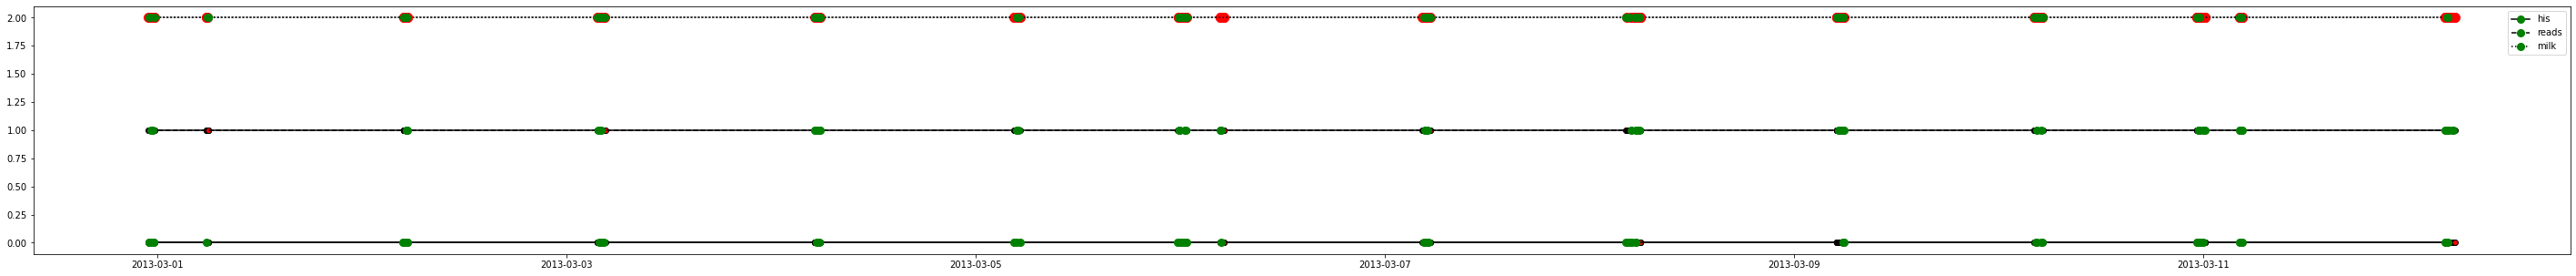

In [108]:
# INSERT HERE : change the names of the series based on the words., change labels in legend
forgotten_1 = trace_his.loc[trace_his['p_forgot_bin']==1,'Datetime']
remembered_1 = trace_his.loc[trace_his['p_forgot_bin']==0,'Datetime']
plt.figure(figsize=(50,5))
plt.plot(forgotten_1.values,[0]*(forgotten_1.shape[0]),markerfacecolor='red',marker='o',color='black')
plt.plot(remembered_1.values,[0]*(remembered_1.shape[0]),markerfacecolor='green',markeredgecolor = 'green',markersize=8,marker='o',color = 'black',label='his')

forgotten_2 = trace_2.loc[trace_2['p_forgot_bin']==1,'Datetime']
remembered_2 = trace_2.loc[trace_2['p_forgot_bin']==0,'Datetime']
plt.plot(forgotten_2.values,[1]*(forgotten_2.shape[0]),markerfacecolor='red',marker='o',color='black')
plt.plot(remembered_2.values,[1]*(remembered_2.shape[0]),markerfacecolor='green',markeredgecolor = 'green',markersize=8,marker='o',color = 'black',linestyle='--',label='reads')

forgotten_3 = trace_3.loc[trace_3['p_forgot_bin']==1,'Datetime']
remembered_3 = trace_3.loc[trace_3['p_forgot_bin']==0,'Datetime']
plt.plot(forgotten_3.values,[2]*(forgotten_3.shape[0]),markerfacecolor='red',marker='o',markeredgecolor = 'red',markersize = 10,color = 'black',linestyle=':')
plt.plot(remembered_3.values,[2]*(remembered_3.shape[0]),markerfacecolor='green',markeredgecolor = 'green',markersize=8,marker='o',color = 'black',linestyle=':',label='milk')
plt.legend()
plt.show()

### <font color = 'cornflowerblue' size= 3>Are students learning more than one language at once?</font>

Summing up the number of languages each user is actively learning in the time-span of the dataset:

In [113]:
num_langs_learning = pd.crosstab(datadf['user_id'],datadf['learning_language']).astype(bool).sum(axis=1).sort_values(ascending=False)

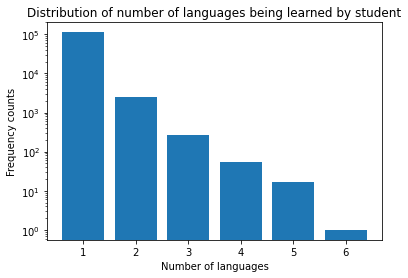

In [146]:
plt.figure()
plt.title("Distribution of number of languages being learned by student")
plt.xlabel("Number of languages")
plt.ylabel("Frequency counts")
plt.bar(num_langs_learning.value_counts().index,num_langs_learning.value_counts(),log=True)
plt.show()

There are some users who are learning multiple languages at the same time. 

In [143]:
# learners learning more than one language 
morethan1_langlearners = num_langs_learning[num_langs_learning>1].index

# getting how many users are learning more than one languages?
print(f"Number of users learning more than one language at once: {len(list(morethan1_langlearners))}")

Number of users learning more than one language at once: 2849


#### Which languages are being learned together?

In [141]:
# subsetting data for users learning more than one language:
datadf_sub = datadf.loc[datadf['user_id'].isin(morethan1_langlearners),:]
# set of languages being learned by each user
lang_sets = datadf_sub.groupby('user_id')['learning_language'].unique().apply(frozenset)
# counts of sets of langauges commonly being learned together:
langs_commonly_learned_together = lang_sets.value_counts()

In [142]:
langs_commonly_learned_together.head(10)

(es, fr)        660
(de, fr)        484
(de, es)        460
(it, fr)        186
(es, it)        145
(de, it)        139
(es, de, fr)     96
(es, pt)         85
(de, en)         64
(en, fr)         60
Name: learning_language, dtype: int64

Spanish and French are learned together by 660 users, while German and French are being learned together by 484 users. 

#### Is learning more than one language related to different performance?

In [149]:
#Records of Users learning only Spanish 
learning_es_only = datadf.loc[(datadf['user_id'].isin(num_langs_learning[num_langs_learning==1].index)) & (datadf['learning_language']=='es')]

# Records of Users learning only French
learning_fr_only = datadf.loc[(datadf['user_id'].isin(num_langs_learning[num_langs_learning==1].index)) & (datadf['learning_language']=='fr')]

# Records of Users learning both:
learning_esandfr = datadf.loc[(datadf['user_id'].isin(num_langs_learning[num_langs_learning==2].index)) & (datadf['learning_language'].isin(['fr','es']))]

In [151]:
learning_es_only['p_forgot_bin'].mean(), learning_fr_only['p_forgot_bin'].mean(), learning_esandfr['p_forgot_bin'].mean()

(0.1569166198120006, 0.18497565266262864, 0.1574391977132272)

In [169]:
ctable_es = pd.concat([learning_es_only['p_forgot_bin'].value_counts(), learning_esandfr.loc[learning_esandfr['learning_language']=='es','p_forgot_bin'].value_counts()],axis=1)
ctable_es.columns = ['Spanish_peformance_spanishonly_learners','Spanish_performance_frandes_learners']

ctable_fr = pd.concat([learning_es_only['p_forgot_bin'].value_counts(), learning_esandfr.loc[learning_esandfr['learning_language']=='fr','p_forgot_bin'].value_counts()],axis=1)
ctable_es.columns = ['French_peformance_frenchonly_learners','Fpanish_performance_frandes_learners']

In [170]:
# Chi-squared test
#display(HTML("<h4>Contingency table of WNV Presence and Mosquito Species</h4>"))
display(ctable_es)

# chi-squared test for independence
chi2stat, p_val, dof,expected = stats.chi2_contingency(ctable_es)
print(f'Chi-squared statistic: {chi2stat}')
print(f'p-value: {p_val}')
print('Expected frequencies (for independence):')
print(expected)

,French_peformance_frenchonly_learners,Fpanish_performance_frandes_learners
0,2661551,176285
1,495374,28753


Chi-squared statistic: 407.13357036240404
p-value: 1.54198397805898e-90
Expected frequencies (for independence):
[[2664763.23930394  173072.76069606]
 [ 492161.76069606   31965.23930394]]


The p-value is << 0.05 so we can reject the null hypothesis that the Spanish perofrmance of students learning only Spanish is the same as the Spanish performance of students learning both Spanish and French. 

In [171]:
# Chi-squared test
#display(HTML("<h4>Contingency table of WNV Presence and Mosquito Species</h4>"))
display(ctable_fr)

# chi-squared test for independence
chi2stat, p_val, dof,expected = stats.chi2_contingency(ctable_fr)
print(f'Chi-squared statistic: {chi2stat}')
print(f'p-value: {p_val}')
print('Expected frequencies (for independence):')
print(expected)

,p_forgot_bin,p_forgot_bin
0,2661551,140287
1,495374,30401


Chi-squared statistic: 546.4789723077567
p-value: 7.344481617981593e-121
Expected frequencies (for independence):
[[2658119.3270221  143718.6729779]
 [ 498805.6729779   26969.3270221]]


The p-value is << 0.05 so we can reject the null hypothesis that the French perofrmance of students learning only French is the same as the French performance of students learning both Spanish and French. 

## <font color = 'cornflowerblue' size= 4>Conclusions and Next Steps</font>


#### Conclusions

- The score of the dataset has been explored. 

- Duplicate rows have been deleted. 

- The dataset has been checked for null values; none were found. 

- The target variable provided in the original dataset, probability of recall, has been analyzed, and based on our findings has been transformed to a conservative binary column marking if a word was forgotten or not. 

 - The effect of variables such as time since last review, language being learned, number of languages being learned, and historical performance have been investigated. Statistical significance tests have been done where applicable.

#### Next Steps:

1. Clean the lexeme string column to individual features. 

2. EDA on word-based features.

## <font color = 'cornflowerblue' size=4>Appendix</font>

- Details of the work published by Duolingo's machine learning team
- Relevant images are included



B. Settles and B. Meeder. 2016. [A Trainable Spaced Repetition Model for Language Learning](https://github.com/duolingo/halflife-regression/blob/master/settles.acl16.pdf). In _Proceedings of the Association for Computational Linguistics (ACL)_, pages 1848-1858.



Learning sessions are segmented in the form of a skill tree, with each skill consisting of a few words belonging to a certain theme (e.g greetings, common foods etc.). Students work their way up the skill tree, and need to have proficiency with the basics before moving onto more advanced lessons.

My capstone project is a spaced repetition [dataset from Duolingo](https://github.com/duolingo/halflife-regression). It spans 14 days of students learning second languages through Duolingo’s gamified system and has almost 13 million records and 12 variables. As part of its plan for engagement, Duolingo predicts how well a student might have retained the meanings and usage of words, and constructs a model of student’s understanding to produce targeted practice sessions that review words before are forgotten, and maximize retention. How well a word is retained depends on the word itself, its similarity to words in the language a student knows, and the student’s individual learning pace, and memory capacity. 

Duolingo’s machine learning team released a solution for predicting a student’s recall of a word with a parameterized half-life regression model based on psychological theory: Ebbinghaus’ model for forgetting, and combines it with machine learning. The main equation is:
****$p = 2^{\frac{-\Delta}{h}}$** 
where $p$ is the probability of a student remembering a word correctly, delta is how much time has passed since the student last reviewed the word, and $h$ is the **_half-life_** parameter, which represents the strength of retention in the student's mind. 

The Duolingo team makes an additional assumption that the half-life parameter increases exponentially with each repeated exposure to the word. 

$\hat{h} = 2^{\theta.x}$

where $\hat{h}$ is the predicted half-life, $x$ is a vector of features describing previous exposures, and $\theta$ is the parameter vector containing weights corresponding to the features in $x$. 

Loss function used was L2 regularized loss function (to avoid over-fitting).

They fit half-life and p_recall simulataneously with the final loss function:
$(p - \hat{p}_{\theta})^2 + \alpha(h-\hat{h}_{\theta})^2+ \lambda|\theta|^2$

where $\alpha$ is a parameter to control the relative importance of the half-life term in the overall objective function.

Since loss function is smooth with respect to theta, weights were fit using gradient descent. 

**Feature sets:**

_Interaction features:_
includes total number of times a student has seen the word $x_n$, the number of times it was correctly recalled, the number of times incorrectly recalled. sometimes square root of these count fatures yielded better results than raw counts.

(Does this mean some sort of log-log model might work well?)
Lexeme tag features: meant to capture the inherent difficulty of each particular word.

Ablation studies were done: removing certain components to understand the contribution of the component to the overall system. Ablation requires that a system exhibit "graceful degradation" - the system must continue to function even when certain components are missing or degraded. Is useful for investigating a model's durability to structural damages. investigates possible outcomes of system failure. 

Models tested:
1. just HLR as described above
2. HLR + lexeme features
3. HLR without half-life in loss function

Compared against baseline models: 
1. Leitner
2. Pimsleur
3. Logistic - with and without lexeme. lag time was an additional feature with either exponential or polynomial transformations. raw lag time worked best. 

They tried a handful of values and settled on lambda =1, alpha = 0.01, and learning rate = 0.001 (gradient descent)

Model evaluation:

1. Mean absolute error in p_recall.
2. Area under ROC curve (Wilcoxon rank-sum test) - 
3. Half-life correlation (Spearkman rank correlation between halflife predicted and the algenbraic estimate h)

HLR with lexeme tag features was the best or second best approach wrt the above evaluation metrics. 

Image 1: Graphing lexical similarity of languages from this [link](https://community.wolfram.com/groups/-/m/t/2033869)

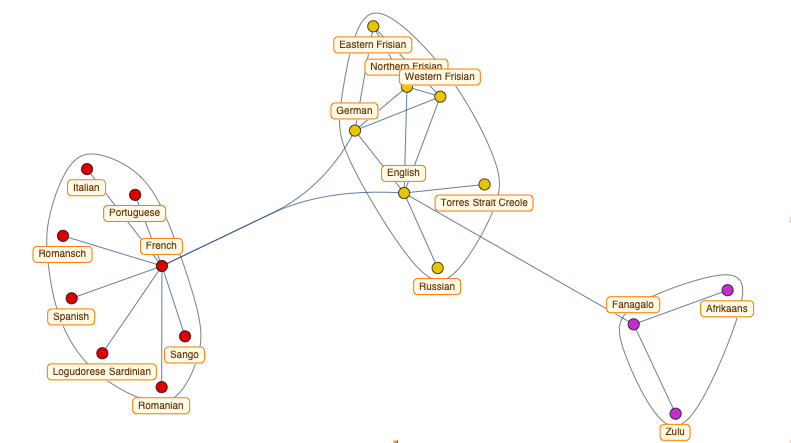